## Mission: Réaliser un algorithme de détection de la race d'un chien à partir de sa photo

### Notebook d'analyse et de prétraitement d'images. 
### Modélisation avec SIFT (sans et avec data augmentation)

## Librairies installées

TensorFlow : bibliothèque complète pour diverses tâches d'apprentissage automatique et profond. Keras, qui est une API de haut niveau pour construire et entraîner des modèles en TensorFlow, est inclus dans TensorFlow 2.x.

OpenCV (Open Source Computer Vision Library) : bibliothèque utilisée pour le traitement d'images et la vision par ordinateur. Elle est essentielle pour effectuer des opérations d'égalisation et de blanchiment des images.

os : bibliothèque utilisée pour interagir avec le système d'exploitation. Elle est utile pour manipuler les chemins de fichiers, parcourir les répertoires, etc.

numpy : bibliothèque essentielle pour le calcul scientifique en Python. Elle est particulièrement utile pour la manipulation de matrices, qui est une opération courante dans le traitement d'images.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import shutil
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random
from PIL import Image
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import time

2024-01-03 12:01:05.803504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset et propriété intellectuelle

http://vision.stanford.edu/aditya86/ImageNetDogs/  
  
https://www.tensorflow.org/datasets/catalog/stanford_dogs?hl=fr#:~:text=Except%20as%20otherwise%20noted%2C%20the,of%20Oracle%20and%2For%20its%20affiliates  

Le contenu de la page TensorFlow Datasets, qui inclut des informations sur le Stanford Dogs Dataset, est sous licence Creative Commons Attribution 4.0. Cette licence permet généralement de partager et d'adapter l'œuvre, tant que l'attribution appropriée est donnée. Les échantillons de code sur cette page sont sous licence Apache 2.0

In [2]:
dossier = 'races_chiens'
nombre_sous_dossiers = len([nom for nom in os.listdir(dossier) if os.path.isdir(os.path.join(dossier, nom))])

print("Nombre de sous-dossiers de races de chiens :", nombre_sous_dossiers)


Nombre de sous-dossiers de races de chiens : 120


In [3]:
nombre_fichiers_total = sum(len(fichiers) for _, _, fichiers in os.walk(dossier))

print("Nombre total d'images :", nombre_fichiers_total)

Nombre total d'images : 20581


In [4]:
extensions = set()

for dossier_courant, sous_dossiers, fichiers in os.walk(dossier):
    for fichier in fichiers:
        _, ext = os.path.splitext(fichier)
        extensions.add(ext.lower())

print("Extensions de fichiers trouvées :", extensions)

Extensions de fichiers trouvées : {'', '.jpg'}


L'ensemble de données Stanford Dogs contient des images de 120 races de chiens du monde entier. Cet ensemble de données a été construit à l'aide d'images et d'annotations d'ImageNet pour la tâche de catégorisation fine des images. Il existe 20 581 images différentes.

Source Originale : Les images du Stanford Dogs Dataset proviennent de ImageNet, qui est une base de données de formation largement utilisée dans la recherche en vision par ordinateur. ImageNet recueille des images de diverses sources publiques, y compris des sites Web.

Utilisation à des Fins de Recherche : Le Stanford Dogs Dataset est destiné principalement à des fins de recherche et d'éducation. Ici ce dataset est bien utilisé dans un contexte académique et non pas de recherche commerciale.

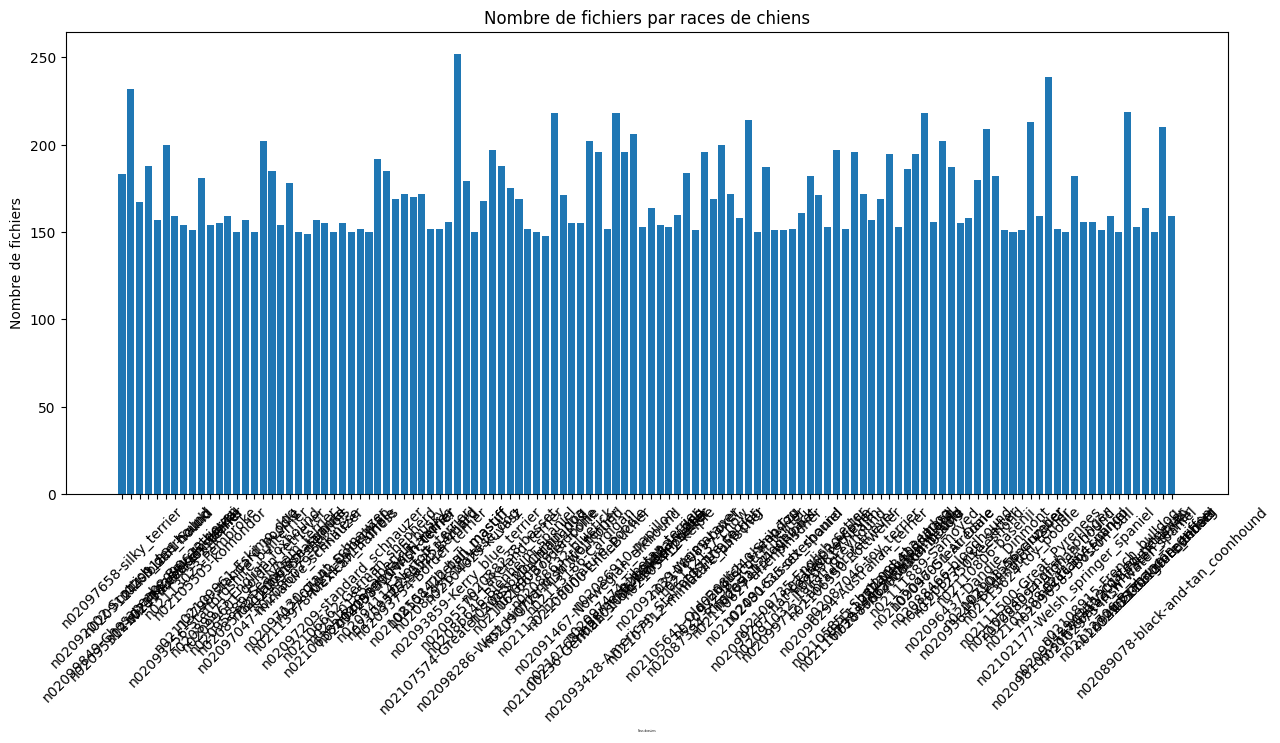

In [5]:
dossier = 'races_chiens'

# Nombre de fichiers dans chaque sous-dossier
nombre_fichiers = {nom: len(os.listdir(os.path.join(dossier, nom))) for nom in os.listdir(dossier) if os.path.isdir(os.path.join(dossier, nom))}

noms_sous_dossiers = list(nombre_fichiers.keys())

comptages = list(nombre_fichiers.values())

plt.figure(figsize=(15, 6))  
plt.bar(noms_sous_dossiers, comptages)
plt.xlabel('Sous-dossiers', fontsize=2)  
plt.xlabel('Sous-dossiers')
plt.ylabel('Nombre de fichiers')
plt.title('Nombre de fichiers par races de chiens')
plt.xticks(rotation=45)  # Faire pivoter les étiquettes si nécessaire
plt.show()

## Dimension des images

In [6]:
dossier = 'races_chiens'
largeurs, hauteurs = [], []

for sous_dossier in os.listdir(dossier):
    chemin_sous_dossier = os.path.join(dossier, sous_dossier)
    if os.path.isdir(chemin_sous_dossier):
        for fichier in os.listdir(chemin_sous_dossier):
            if fichier.endswith(('.png', '.jpg', '.jpeg')):  # Ajoutez d'autres formats si nécessaire
                chemin_image = os.path.join(chemin_sous_dossier, fichier)
                with Image.open(chemin_image) as img:
                    largeur, hauteur = img.size
                    largeurs.append(largeur)
                    hauteurs.append(hauteur)

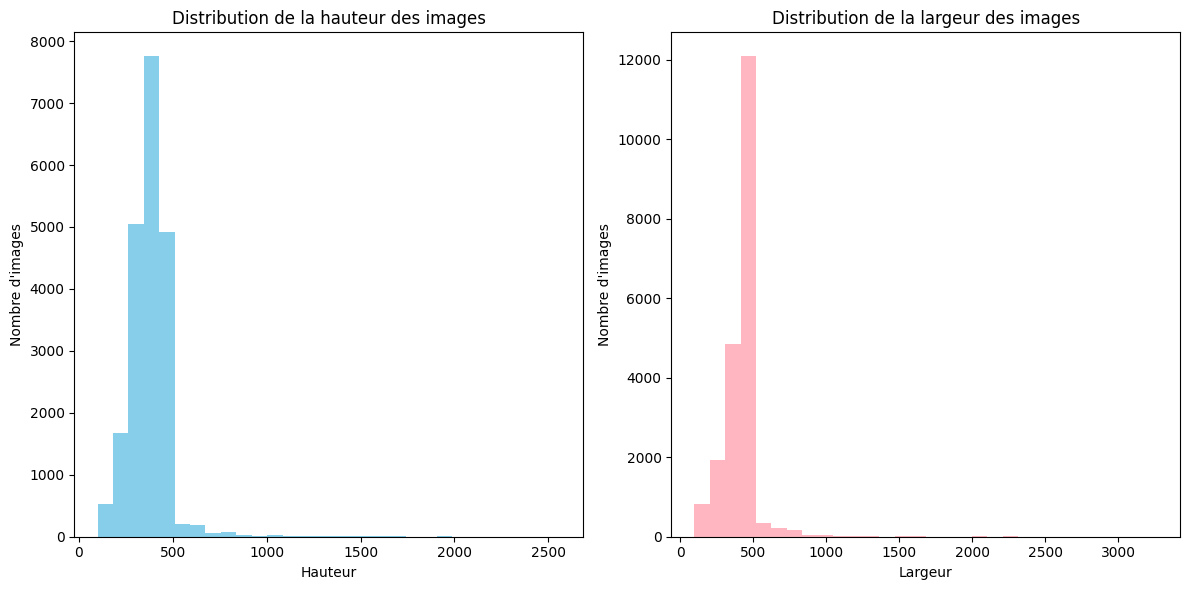

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(hauteurs, color='skyblue', bins=30)
ax1.set_title('Distribution de la hauteur des images')
ax1.set_xlabel('Hauteur')
ax1.set_ylabel('Nombre d\'images')

ax2.hist(largeurs, color='lightpink', bins=30)
ax2.set_title('Distribution de la largeur des images')
ax2.set_xlabel('Largeur')
ax2.set_ylabel('Nombre d\'images')

plt.tight_layout()
plt.show()

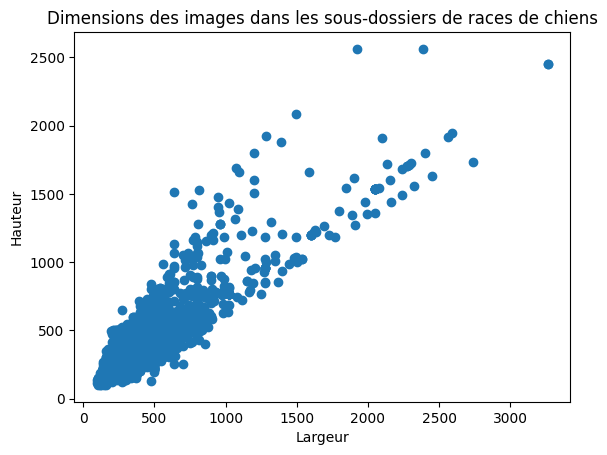

In [8]:
plt.scatter(largeurs, hauteurs)
plt.xlabel('Largeur')
plt.ylabel('Hauteur')
plt.title('Dimensions des images dans les sous-dossiers de races de chiens')
plt.show()

Les plus hautes fréquences sont pour une largeur d'image entre 400 et 500 pixels et une hauteur entre 300 et 400 pixels. Certaines images ont des dimensions allant au-delà des 2500 pixels.  


## Redimensionnement

`Pourquoi redimensionner ?`  
Les images de grande taille augmentent la complexité computationnelle, car elles contiennent plus de pixels à traiter. Redimensionner les images en dimensions plus petites réduit le nombre de calculs nécessaires, ce qui rend l'entraînement plus rapide et moins coûteux en termes de ressources.

`D'autres raisons de redimensionner pour la suite du projet (dans le cadre des réseaux de neurones convolutifs):`   
Uniformité des Entrées : Les CNN nécessitent que toutes les images en entrée aient la même taille. Redimensionner garantit cette uniformité.  
Compatibilité avec l'Architecture du Modèle : De nombreux modèles pré-entraînés et architectures de CNN populaires ont été conçus et entraînés sur des images de tailles spécifiques (par exemple, 224x224 pour VGG16 ou encore 256 x 256, 299 x 299, ou 512 x 512 pixels pour d'autres modèles comment ResNet, Inception...). Pour utiliser ces modèles avec un transfert d'apprentissage, il est important de correspondre à leur taille d'entrée attendue.  
`On utilisera VGG16 plus loin dans le projet. On redimensionnera donc ici toutes les images en 224x224 pixels.`   

In [9]:
source_dossier = 'races_chiens'
destination_dossier = 'races_chiens_224'

# Suppression du dossier de destination s'il existe
if os.path.exists(destination_dossier):
    shutil.rmtree(destination_dossier)

os.makedirs(destination_dossier, exist_ok=True)

for dossier in os.listdir(source_dossier):
    sous_dossier_source = os.path.join(source_dossier, dossier)
    
    if os.path.isdir(sous_dossier_source):
        sous_dossier_destination = os.path.join(destination_dossier, dossier)
        os.makedirs(sous_dossier_destination, exist_ok=True)

        for fichier in os.listdir(sous_dossier_source):
            fichier_source = os.path.join(sous_dossier_source, fichier)
            fichier_destination = os.path.join(sous_dossier_destination, fichier)

            image = cv2.imread(fichier_source)
            image_redimensionnee = cv2.resize(image, (224, 224))

            cv2.imwrite(fichier_destination, image_redimensionnee)
